In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings
import yaml
from mpl_toolkits.axes_grid1 import make_axes_locatable

import evolution
warnings.filterwarnings('ignore')

plots_folder = "./Figures/"

In [2]:
Mp  = 1.
XFe = 65.
FeM = 0.
S = 0.11

Planet = evolution.Rocky_Planet(Mp, XFe, FeM, S)

7292.515328607809 526.5643951000001 0.11
1900668.4440028335


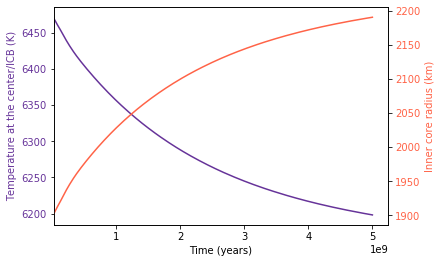

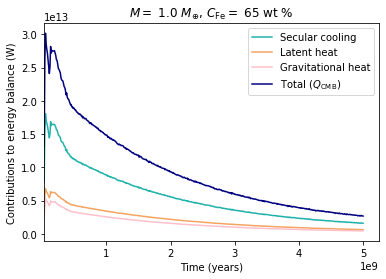

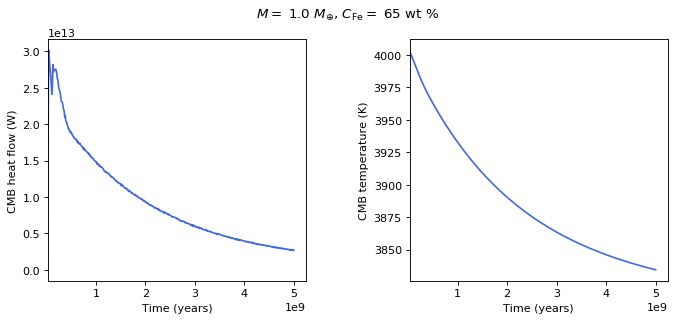

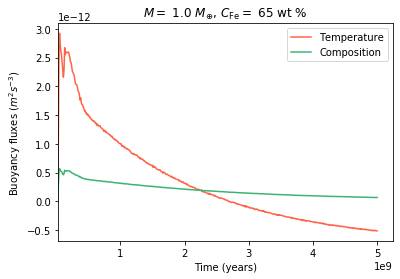

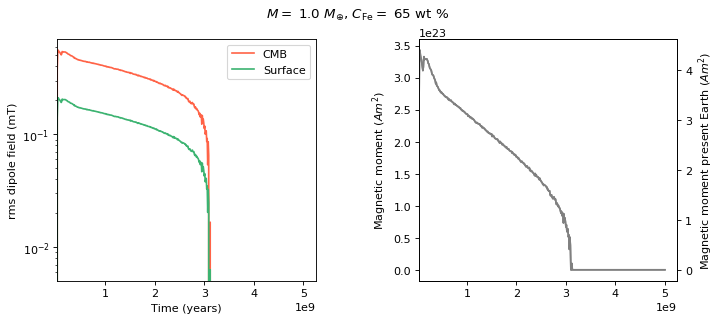

In [3]:
evolution.Evolution(Planet).run(plots_folder,plot=True)

In [5]:
Masses = [0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.8, 2.]
Fe = [15,25,35,45,55,65,75]
Fe_mantle = [0.00,0.1,0.2]
S = 0.0

M, F = np.meshgrid(Masses, Fe)
r_IC_end = np.zeros((len(Fe),len(Masses)*len(Fe_mantle)))
MF_lifetime = np.zeros_like(r_IC_end)
Q_CMB_end = np.zeros_like(r_IC_end)
Q_CMB_beginning = np.zeros_like(r_IC_end)
r_OC = np.zeros_like(r_IC_end)

for m,iron_mantle in enumerate(Fe_mantle):
    print (m)
    for i, mass in enumerate(Masses):
        for j,iron in enumerate(Fe):
            Mp = mass
            XFe = iron
            FeM = iron_mantle
            evo = evolution.Evolution(evolution.Rocky_Planet(Mp,XFe,FeM,S))

            evo.run(plot=False)

            r_IC_end[j,i+m*len(Masses)] = evo.r_IC[-1]/1e3      
            r_OC[j,i+m*len(Masses)] = evo.planet.r_OC/1e3
            MF_lifetime[j,i+m*len(Masses)] = evo.t_mf           
            Q_CMB_end[j,i+m*len(Masses)] = evo.Q_CMB[-1]        
            Q_CMB_beginning[j,i+m*len(Masses)] = evo.Q_CMB[1]

0


FileNotFoundError: [Errno 2] No such file or directory: './Ini_With_DTcmb/data_prof_M_ 0.8_Fe_15.0000_FeM_ 0.0000.yaml'

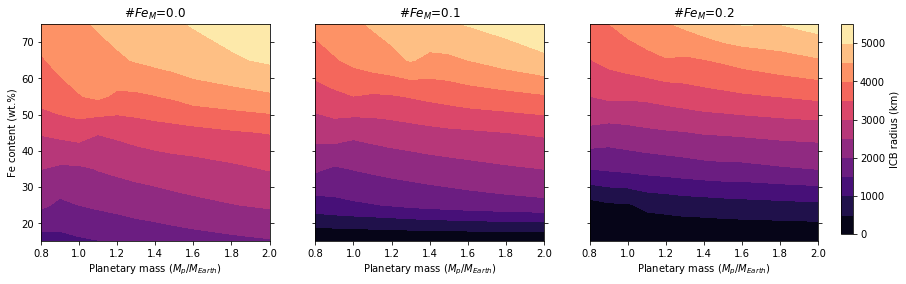

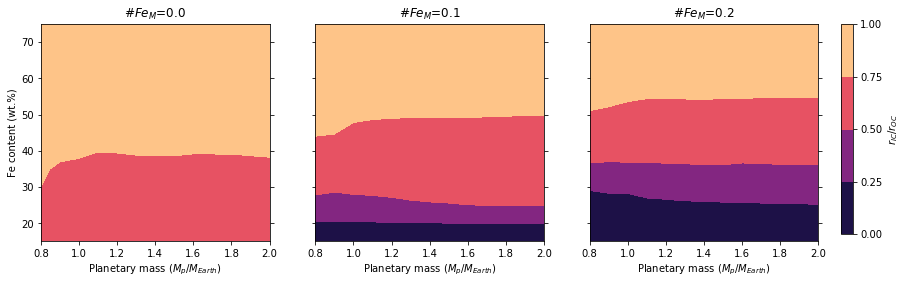

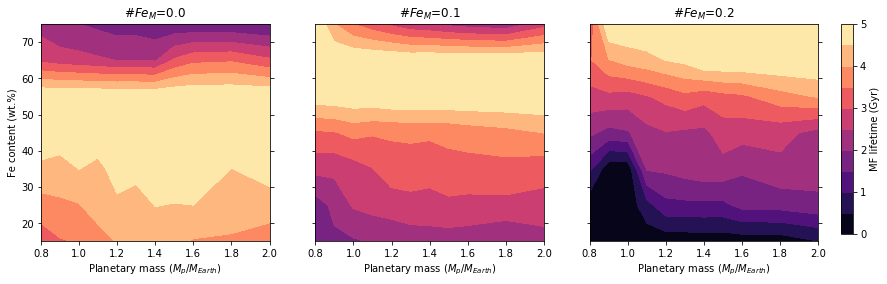

In [15]:
fig, ax = plt.subplots(1, len(Fe_mantle), figsize=[16,4],sharey=True,sharex=True)
plt.subplots_adjust(wspace = 0.2)

levels_rIC = np.linspace(0, 5500, 12)
for i in range(len(Fe_mantle)):
    sc = ax[i].contourf(M,F,r_IC_end[:,i*len(Masses):len(Masses)*(i+1)],levels_rIC, cmap = plt.cm.magma)  
    if i!=0:
        ax[i].set_ylabel("")
    else:
        ax[i].set_ylabel("Fe content (wt.%)")
    ax[i].set_title('#$Fe_M$={}'.format(Fe_mantle[i]))
    ax[i].yaxis.set_ticks_position('both')
    ax[i].set_xlabel("Planetary mass ($M_{p}/M_{Earth}$)")
    ax[i].yaxis.set_ticks_position('both')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.15, 0.01, 0.73])
cb = fig.colorbar(sc, cax=cbar_ax)
cb.set_label("ICB radius (km)")
plt.savefig(plots_folder +"r_IC.pdf", bbox_inches="tight")
plt.show()

fig, ax = plt.subplots(1, len(Fe_mantle), figsize=[16,4],sharey=True,sharex=True)
plt.subplots_adjust(wspace = 0.2)

levels_ICMF = np.linspace(0, 1, 5)
for i in range(len(Fe_mantle)):
    sc = ax[i].contourf(M,F,r_IC_end[:,i*len(Masses):len(Masses)*(i+1)]/r_OC[:,i*len(Masses):len(Masses)*(i+1)],levels_ICMF, cmap = plt.cm.magma)  
    if i!=0:
        ax[i].set_ylabel("")
    else:
        ax[i].set_ylabel("Fe content (wt.%)")
    ax[i].set_title('#$Fe_M$={}'.format(Fe_mantle[i]))
    ax[i].yaxis.set_ticks_position('both')
    ax[i].set_xlabel("Planetary mass ($M_{p}/M_{Earth}$)")
    ax[i].yaxis.set_ticks_position('both')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.15, 0.01, 0.73])
cb = fig.colorbar(sc, cax=cbar_ax)
cb.set_label("$r_{IC}$/$r_{OC}$")
plt.savefig(plots_folder +"ICMF.pdf", bbox_inches="tight")
plt.show()

fig, ax = plt.subplots(1, len(Fe_mantle), figsize=[16,4],sharey=True,sharex=True)
plt.subplots_adjust(wspace = 0.2)

levels_MF = np.linspace(0, 5, 11)
for i in range(len(Fe_mantle)):
    sc = ax[i].contourf(M,F,MF_lifetime[:,i*len(Masses):len(Masses)*(i+1)],levels_MF, cmap = plt.cm.magma)  
    if i!=0:
        ax[i].set_ylabel("")
    else:
        ax[i].set_ylabel("Fe content (wt.%)")
    ax[i].set_title('#$Fe_M$={}'.format(Fe_mantle[i]))
    ax[i].yaxis.set_ticks_position('both')
    ax[i].set_xlabel("Planetary mass ($M_{p}/M_{Earth}$)")
    ax[i].yaxis.set_ticks_position('both')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.15, 0.01, 0.73])
cb = fig.colorbar(sc, cax=cbar_ax)
cb.set_label("MF lifetime (Gyr)")
plt.savefig(plots_folder +"MF_lifetime.pdf", bbox_inches="tight")
plt.show()

In [6]:
Masses_ = [0.8, 1.0, 1.5, 2.]
Fe = [15,25,35,45,55,65,75]
Fe_mantle_ = [0.00,0.05,0.1,0.15,0.2]
S = 0.0

FE, FM = np.meshgrid(Fe,Fe_mantle_)
r_IC_end_M = np.zeros((len(Fe_mantle_),len(Masses_)*len(Fe)))
MF_lifetime_M = np.zeros_like(r_IC_end_M)
Q_CMB_end_M = np.zeros_like(r_IC_end_M)
r_OC_M = np.zeros_like(r_IC_end_M)

for m,mass in enumerate(Masses_):
    for i, iron in enumerate(Fe):
        for j,iron_mantle in enumerate(Fe_mantle_):
            Mp = mass
            XFe = iron
            FeM = iron_mantle
            evo = evolution.Evolution(evolution.Exo(Mp,XFe,FeM,S))
            evo.run(plot=False)
            r_IC_end_M[j,i+m*len(Fe)] = evo.r_IC[-1]/1e3      
            r_OC_M[j,i+m*len(Fe)] = evo.planet.r_OC/1e3
            MF_lifetime_M[j,i+m*len(Fe)] = evo.t_mf           
            Q_CMB_end_M[j,i+m*len(Fe)] = evo.Q_CMB[-1] 

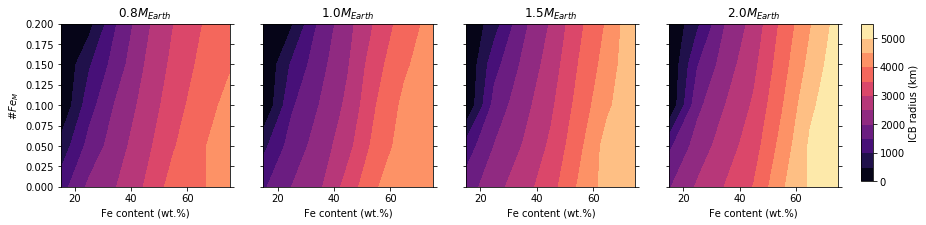

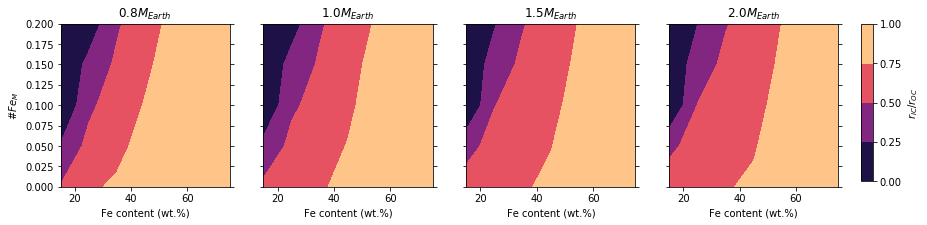

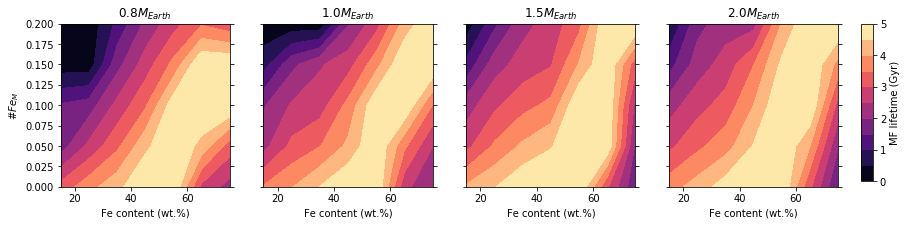

In [7]:
fig, ax = plt.subplots(1, len(Masses_), figsize=[16,3],sharey=True,sharex=True)
plt.subplots_adjust(wspace = 0.2)

levels_rIC = np.linspace(0, 5500, 12)
for i in range(len(Masses_)):
    sc = ax[i].contourf(FE,FM,r_IC_end_M[:,i*len(Fe):len(Fe)*(i+1)],levels_rIC, cmap = plt.cm.magma)  
    if i!=0:
        ax[i].set_ylabel("")
    else:
        ax[i].set_ylabel("#$Fe_{M}$")
    ax[i].set_title("{:.1f}".format(Masses_[i]) + r"$M_{Earth}$")
    ax[i].yaxis.set_ticks_position('both')
    ax[i].set_xlabel("Fe content (wt.%)")
    ax[i].yaxis.set_ticks_position('both')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.15, 0.01, 0.73])
cb = fig.colorbar(sc, cax=cbar_ax)
cb.set_label("ICB radius (km)")
plt.savefig(plots_folder +"r_IC_M.pdf", bbox_inches="tight")
plt.show()

fig, ax = plt.subplots(1, len(Masses_), figsize=[16,3],sharey=True,sharex=True)
plt.subplots_adjust(wspace = 0.2)

levels_ICMF = np.linspace(0, 1, 5)
for i in range(len(Masses_)):
    sc = ax[i].contourf(FE,FM,r_IC_end_M[:,i*len(Fe):len(Fe)*(i+1)]/r_OC_M[:,i*len(Fe):len(Fe)*(i+1)],levels_ICMF, cmap = plt.cm.magma)  
    if i!=0:
        ax[i].set_ylabel("")
    else:
         ax[i].set_ylabel("#$Fe_{M}$")
    ax[i].set_title("{:.1f}".format(Masses_[i]) + r"$M_{Earth}$")
    ax[i].yaxis.set_ticks_position('both')
    ax[i].set_xlabel("Fe content (wt.%)")
    ax[i].yaxis.set_ticks_position('both')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.15, 0.01, 0.73])
cb = fig.colorbar(sc, cax=cbar_ax)
cb.set_label("$r_{IC}$/$r_{OC}$")
plt.savefig(plots_folder +"ICMF_M.pdf", bbox_inches="tight")
plt.show()

fig, ax = plt.subplots(1, len(Masses_), figsize=[16,3],sharey=True,sharex=True)
plt.subplots_adjust(wspace = 0.2)

levels_MF = np.linspace(0, 5, 11)
for i in range(len(Masses_)):
    sc = ax[i].contourf(FE,FM,MF_lifetime_M[:,i*len(Fe):len(Fe)*(i+1)],levels_MF, cmap = plt.cm.magma)  
    if i!=0:
        ax[i].set_ylabel("")
    else:
        ax[i].set_ylabel("#$Fe_{M}$")
    ax[i].set_title("{:.1f}".format(Masses_[i]) + r"$M_{Earth}$")
    ax[i].yaxis.set_ticks_position('both')
    ax[i].set_xlabel("Fe content (wt.%)")
    ax[i].yaxis.set_ticks_position('both')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.15, 0.01, 0.73])
cb = fig.colorbar(sc, cax=cbar_ax)
cb.set_label("MF lifetime (Gyr)")
plt.savefig(plots_folder +"MF_lifetime_M.pdf".format(Fe_mantle), bbox_inches="tight")
plt.show()